# Research on Weather
In this notebook we will research the weather data to come up with ways of reasoning over cities and their weather.  The goal is to understand cities that are similar (e.g. cities in the North East) but might be separated by vast areas.

We also want to classify things like cities that have cold/hot or wet/dry seasons, measured hollistically and locally (i.e. what is wet for one area might not be wet for another).  This should result in a dataset like city, state, year, season, local_temperature_rating, global_temperature_rating, local_precip_rating, global_precip_rating.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the weather data
WEATHER_DATA = "../data/weather_data_v2.csv"
df = pd.read_csv(WEATHER_DATA)

print(f"Loaded {len(df):,} daily weather records")
print("="*80)

# Convert date to datetime and extract time components
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Define season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

df['season'] = df['month'].apply(get_season)

# Calculate average temperature
df['avg_temp'] = (df['temp_min'] + df['temp_max']) / 2

print(f"\nData spans years: {df['year'].min()} - {df['year'].max()}")
print(f"\nUnique cities: {df['city'].nunique()}")
print(f"Unique city/state combinations: {df.groupby(['city', 'state']).ngroups}")

print(f"\nSeason distribution:")
print(df['season'].value_counts())

print("\nWeather features summary:")
print(df[['temp_min', 'temp_max', 'avg_temp', 'precip']].describe())

Loaded 821,498 daily weather records

Data spans years: 1999 - 2026

Unique cities: 85
Unique city/state combinations: 85

Season distribution:
season
Spring    206319
Summer    206264
Winter    204893
Fall      204022
Name: count, dtype: int64

Weather features summary:
            temp_min       temp_max       avg_temp         precip
count  821498.000000  821498.000000  821498.000000  821498.000000
mean       49.536972      67.638242      58.587607       2.429629
std        17.247268      18.393883      17.454107       6.584599
min       -36.900000     -16.200000     -24.150000       0.000000
25%        38.000000      55.300000      46.900000       0.000000
50%        51.000000      69.900000      60.350000       0.000000
75%        62.800000      81.800000      72.350000       1.300000
max        95.400000     118.500000     104.100000     239.500000


## Step 1: Calculate City-Season-Year Weather Aggregates
Group by city, state, year, and season to get average weather conditions.

In [21]:
# Group by city, state, year, season and calculate weather statistics
city_season_weather = df.groupby(['city', 'state', 'year', 'season']).agg(
    avg_temp_min=('temp_min', 'mean'),
    avg_temp_max=('temp_max', 'mean'),
    avg_temp=('avg_temp', 'mean'),
    avg_precip=('precip', 'mean'),
    total_precip=('precip', 'sum'),
    days_with_precip=('precip', lambda x: (x > 0).sum()),
    day_count=('date', 'count')
).reset_index()

print(f"City-season-year combinations: {len(city_season_weather):,}")
print("="*80)

# Filter to combinations with sufficient data (at least 30 days in the season)
city_season_weather = city_season_weather[city_season_weather['day_count'] >= 30]

print(f"After filtering (≥30 days): {len(city_season_weather):,}")
print("\nSample of aggregated data:")
print(city_season_weather.head(10))

# Calculate temperature range for each city-season-year
city_season_weather['temp_range'] = city_season_weather['avg_temp_max'] - city_season_weather['avg_temp_min']

print("\nWeather statistics by season:")
print(city_season_weather.groupby('season')[['avg_temp_min', 'avg_temp_max', 'avg_temp', 'avg_precip']].describe())

City-season-year combinations: 9,095
After filtering (≥30 days): 9,010

Sample of aggregated data:
          city state  year  season  avg_temp_min  avg_temp_max   avg_temp  \
0  albuquerque    nm  1999    Fall     48.592308     72.206593  60.399451   
1  albuquerque    nm  1999  Spring     43.410870     69.431522  56.421196   
2  albuquerque    nm  1999  Summer     63.388043     86.606522  74.997283   
3  albuquerque    nm  1999  Winter     31.618889     52.231111  41.925000   
4  albuquerque    nm  2000    Fall     45.143956     66.204396  55.674176   
5  albuquerque    nm  2000  Spring     45.910870     72.245652  59.078261   
6  albuquerque    nm  2000  Summer     66.541304     90.710870  78.626087   
7  albuquerque    nm  2000  Winter     30.402198     52.621978  41.512088   
8  albuquerque    nm  2001    Fall     49.689011     72.483516  61.086264   
9  albuquerque    nm  2001  Spring     45.586957     71.531522  58.559239   

   avg_precip  total_precip  days_with_precip  day_co

## Step 2: Create Global Ratings (Absolute Comparisons)
Classify weather conditions using absolute thresholds that apply to all cities.

In [22]:
# Create global temperature rating (5-point scale)
# Calculate global quintiles for temperature
temp_quintiles = city_season_weather['avg_temp'].quantile([0.2, 0.4, 0.6, 0.8])

def global_temp_rating(temp):
    """Rate temperature on a 5-point scale: 1=Very Cold, 5=Very Hot"""
    if temp < temp_quintiles[0.2]:
        return 1  # Very Cold
    elif temp < temp_quintiles[0.4]:
        return 2  # Cold
    elif temp < temp_quintiles[0.6]:
        return 3  # Moderate
    elif temp < temp_quintiles[0.8]:
        return 4  # Hot
    else:
        return 5  # Very Hot

city_season_weather['global_temperature_rating'] = city_season_weather['avg_temp'].apply(global_temp_rating)

# Calculate global quintiles for precipitation
precip_quintiles = city_season_weather['avg_precip'].quantile([0.2, 0.4, 0.6, 0.8])

def global_precip_rating(precip):
    """Rate precipitation on a 5-point scale: 1=Very Dry, 5=Very Wet"""
    if precip < precip_quintiles[0.2]:
        return 1  # Very Dry
    elif precip < precip_quintiles[0.4]:
        return 2  # Dry
    elif precip < precip_quintiles[0.6]:
        return 3  # Moderate
    elif precip < precip_quintiles[0.8]:
        return 4  # Wet
    else:
        return 5  # Very Wet

city_season_weather['global_precip_rating'] = city_season_weather['avg_precip'].apply(global_precip_rating)

print("Global Temperature Quintiles (°F):")
print(f"  Very Cold (<{temp_quintiles[0.2]:.1f}°F)")
print(f"  Cold ({temp_quintiles[0.2]:.1f}°F - {temp_quintiles[0.4]:.1f}°F)")
print(f"  Moderate ({temp_quintiles[0.4]:.1f}°F - {temp_quintiles[0.6]:.1f}°F)")
print(f"  Hot ({temp_quintiles[0.6]:.1f}°F - {temp_quintiles[0.8]:.1f}°F)")
print(f"  Very Hot (>{temp_quintiles[0.8]:.1f}°F)")

print("\nGlobal Precipitation Quintiles (inches/day):")
print(f"  Very Dry (<{precip_quintiles[0.2]:.3f} in/day)")
print(f"  Dry ({precip_quintiles[0.2]:.3f} - {precip_quintiles[0.4]:.3f} in/day)")
print(f"  Moderate ({precip_quintiles[0.4]:.3f} - {precip_quintiles[0.6]:.3f} in/day)")
print(f"  Wet ({precip_quintiles[0.6]:.3f} - {precip_quintiles[0.8]:.3f} in/day)")
print(f"  Very Wet (>{precip_quintiles[0.8]:.3f} in/day)")

print("\n" + "="*80)
print("Global rating distribution:")
print("\nTemperature:")
print(city_season_weather['global_temperature_rating'].value_counts().sort_index())
print("\nPrecipitation:")
print(city_season_weather['global_precip_rating'].value_counts().sort_index())

Global Temperature Quintiles (°F):
  Very Cold (<46.8°F)
  Cold (46.8°F - 55.3°F)
  Moderate (55.3°F - 63.0°F)
  Hot (63.0°F - 72.2°F)
  Very Hot (>72.2°F)

Global Precipitation Quintiles (inches/day):
  Very Dry (<0.849 in/day)
  Dry (0.849 - 1.911 in/day)
  Moderate (1.911 - 2.747 in/day)
  Wet (2.747 - 3.671 in/day)
  Very Wet (>3.671 in/day)

Global rating distribution:

Temperature:
global_temperature_rating
1    1802
2    1802
3    1802
4    1802
5    1802
Name: count, dtype: int64

Precipitation:
global_precip_rating
1    1801
2    1802
3    1803
4    1802
5    1802
Name: count, dtype: int64


## Step 3: Create Local Ratings (Relative to Each City's Norms)
Classify weather conditions relative to each city's own historical patterns. A "hot" day in Seattle is different from a "hot" day in Phoenix.

In [23]:
# For each city, calculate local ratings by iterating through unique cities
print("Calculating local ratings for each city...")

# Initialize columns
city_season_weather['local_temperature_rating'] = 3
city_season_weather['local_precip_rating'] = 3

# Get unique city/state combinations
cities = city_season_weather[['city', 'state']].drop_duplicates()

for _, row in cities.iterrows():
    city, state = row['city'], row['state']
    
    # Get mask for this city
    mask = (city_season_weather['city'] == city) & (city_season_weather['state'] == state)
    city_data = city_season_weather[mask]
    
    # Skip if too few observations
    if len(city_data) < 5:
        continue
    
    # Calculate temperature ratings
    try:
        temp_quintiles = city_data['avg_temp'].quantile([0.2, 0.4, 0.6, 0.8])
        
        def local_temp_rating(temp):
            if pd.isna(temp):
                return 3
            if temp < temp_quintiles[0.2]:
                return 1
            elif temp < temp_quintiles[0.4]:
                return 2
            elif temp < temp_quintiles[0.6]:
                return 3
            elif temp < temp_quintiles[0.8]:
                return 4
            else:
                return 5
        
        city_season_weather.loc[mask, 'local_temperature_rating'] = city_data['avg_temp'].apply(local_temp_rating).values
    except:
        pass
    
    # Calculate precipitation ratings
    try:
        precip_quintiles = city_data['avg_precip'].quantile([0.2, 0.4, 0.6, 0.8])
        
        def local_precip_rating(precip):
            if pd.isna(precip):
                return 3
            if precip < precip_quintiles[0.2]:
                return 1
            elif precip < precip_quintiles[0.4]:
                return 2
            elif precip < precip_quintiles[0.6]:
                return 3
            elif precip < precip_quintiles[0.8]:
                return 4
            else:
                return 5
        
        city_season_weather.loc[mask, 'local_precip_rating'] = city_data['avg_precip'].apply(local_precip_rating).values
    except:
        pass

print("Done!")
print("="*80)

print("\nLocal rating distribution:")
print("\nTemperature:")
print(city_season_weather['local_temperature_rating'].value_counts().sort_index())
print("\nPrecipitation:")
print(city_season_weather['local_precip_rating'].value_counts().sort_index())

# Show examples comparing global vs local ratings
print("\n" + "="*80)
print("Example: Global vs Local ratings for different cities")
print("="*80)

# Pick a few diverse cities
example_cities = [
    ('phoenix', 'az'),
    ('seattle', 'wa'),
    ('chicago', 'il'),
    ('miami', 'fl')
]

for city, state in example_cities:
    city_data = city_season_weather[
        (city_season_weather['city'] == city) & 
        (city_season_weather['state'] == state)
    ]
    if len(city_data) > 0:
        print(f"\n{city.title()}, {state.upper()}:")
        print(f"  Temp range: {city_data['avg_temp'].min():.1f}°F - {city_data['avg_temp'].max():.1f}°F")
        print(f"  Precip range: {city_data['avg_precip'].min():.1f} - {city_data['avg_precip'].max():.1f} inches/day")
        print(f"  Global ratings: Temp {int(city_data['global_temperature_rating'].min())}-{int(city_data['global_temperature_rating'].max())}, Precip {int(city_data['global_precip_rating'].min())}-{int(city_data['global_precip_rating'].max())}")
        print(f"  Local ratings: Temp {int(city_data['local_temperature_rating'].min())}-{int(city_data['local_temperature_rating'].max())}, Precip {int(city_data['local_precip_rating'].min())}-{int(city_data['local_precip_rating'].max())}")

Calculating local ratings for each city...
Done!

Local rating distribution:

Temperature:
local_temperature_rating
1    1819
2    1776
3    1818
4    1777
5    1820
Name: count, dtype: int64

Precipitation:
local_precip_rating
1    1818
2    1774
3    1820
4    1777
5    1821
Name: count, dtype: int64

Example: Global vs Local ratings for different cities

Phoenix, AZ:
  Temp range: 50.7°F - 95.4°F
  Precip range: 0.0 - 3.3 inches/day
  Global ratings: Temp 2-5, Precip 1-4
  Local ratings: Temp 1-5, Precip 1-5

Seattle, WA:
  Temp range: 37.4°F - 67.7°F
  Precip range: 0.3 - 8.0 inches/day
  Global ratings: Temp 1-4, Precip 1-5
  Local ratings: Temp 1-5, Precip 1-5

Chicago, IL:
  Temp range: 21.4°F - 76.4°F
  Precip range: 0.8 - 5.6 inches/day
  Global ratings: Temp 1-5, Precip 1-5
  Local ratings: Temp 1-5, Precip 1-5


## Step 4: Identify Similar Cities Using Clustering
Group cities by their overall weather patterns to find similar climates.

Cities with sufficient data: 85

City profile statistics:
       avg_temp_overall  temp_variability  avg_precip_overall  \
count         85.000000         85.000000           85.000000   
mean          58.520387         12.381611            2.420432   
std            7.895297          3.749482            1.111783   
min           36.888569          2.298878            0.547049   
25%           52.428711          9.615358            1.303099   
50%           58.237027         13.425498            2.819831   
75%           63.835260         14.743826            3.168526   
max           75.593340         19.280879            5.046416   

       precip_variability  temp_range_avg  num_observations  
count           85.000000       85.000000         85.000000  
mean             1.140672       18.100081        106.000000  
std              0.423538        3.808615          5.161672  
min              0.308791        6.817590         61.000000  
25%              0.872567       16.409934     

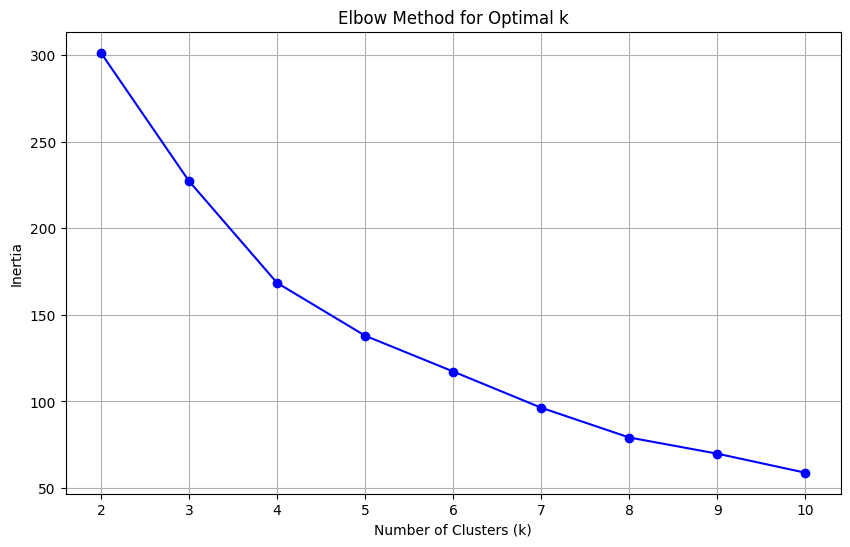


Cluster distribution:
cluster
0    19
1    28
2     9
3    16
4    13
Name: count, dtype: int64

Cluster Characteristics:
         avg_temp_overall  temp_variability  avg_precip_overall  \
cluster                                                           
0               63.722980         12.418487            3.160320   
1               52.840841         15.590510            2.866460   
2               57.522823          8.874194            3.882209   
3               63.346368          6.772498            1.075930   
4               57.900421         14.747979            1.021155   

         precip_variability  temp_range_avg  
cluster                                      
0                  1.198593       17.317315  
1                  0.979627       16.415746  
2                  2.072572       14.647691  
3                  1.227389       19.051597  
4                  0.650992       24.090945  

Example cities in each cluster:

Cluster 0 (19 cities):
  Characteristics: Moderate 

In [24]:
# Calculate average weather characteristics for each city
city_profiles = city_season_weather.groupby(['city', 'state']).agg(
    avg_temp_overall=('avg_temp', 'mean'),
    temp_variability=('avg_temp', 'std'),
    avg_precip_overall=('avg_precip', 'mean'),
    precip_variability=('avg_precip', 'std'),
    temp_range_avg=('temp_range', 'mean'),
    num_observations=('year', 'count')  # Count number of season-year combinations
).reset_index()

# Filter to cities with sufficient data (at least 20 season-year combinations ~5 years)
city_profiles = city_profiles[city_profiles['num_observations'] >= 20]

print(f"Cities with sufficient data: {len(city_profiles)}")
print("\nCity profile statistics:")
print(city_profiles.describe())

# Prepare features for clustering
feature_cols = ['avg_temp_overall', 'temp_variability', 'avg_precip_overall', 
                'precip_variability', 'temp_range_avg']

# Handle any missing values
city_profiles_clean = city_profiles.dropna(subset=feature_cols)
print(f"\nCities after removing missing values: {len(city_profiles_clean)}")

# Standardize features for clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(city_profiles_clean[feature_cols])

# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Use k=5 clusters (reasonable balance)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
city_profiles_clean['cluster'] = kmeans.fit_predict(features_scaled)

print(f"\nCluster distribution:")
print(city_profiles_clean['cluster'].value_counts().sort_index())

# Show characteristics of each cluster
print("\n" + "="*80)
print("Cluster Characteristics:")
print("="*80)

cluster_summary = city_profiles_clean.groupby('cluster')[feature_cols].mean()
print(cluster_summary)

# Show example cities from each cluster
print("\n" + "="*80)
print("Example cities in each cluster:")
print("="*80)

for cluster_id in range(n_clusters):
    cluster_cities = city_profiles_clean[city_profiles_clean['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_cities)} cities):")
    
    # Describe the cluster characteristics
    avg_temp = cluster_cities['avg_temp_overall'].mean()
    avg_precip = cluster_cities['avg_precip_overall'].mean()
    temp_var = cluster_cities['temp_variability'].mean()
    
    # Label the cluster
    temp_label = "Hot" if avg_temp > 65 else "Cold" if avg_temp < 50 else "Moderate"
    precip_label = "Wet" if avg_precip > 4 else "Dry" if avg_precip < 2 else "Moderate"
    variability_label = "High variability" if temp_var > 15 else "Low variability"
    
    print(f"  Characteristics: {temp_label} & {precip_label} ({variability_label})")
    print(f"  Avg temp: {avg_temp:.1f}°F, Avg precip: {avg_precip:.1f} in/day")
    
    # Show some example cities
    examples = cluster_cities.head(10)
    for _, row in examples.iterrows():
        print(f"    - {row['city'].title()}, {row['state'].upper()}")

## Step 5: Visualize City Clusters
Create visualizations to understand the geographic and climatic patterns of city clusters.

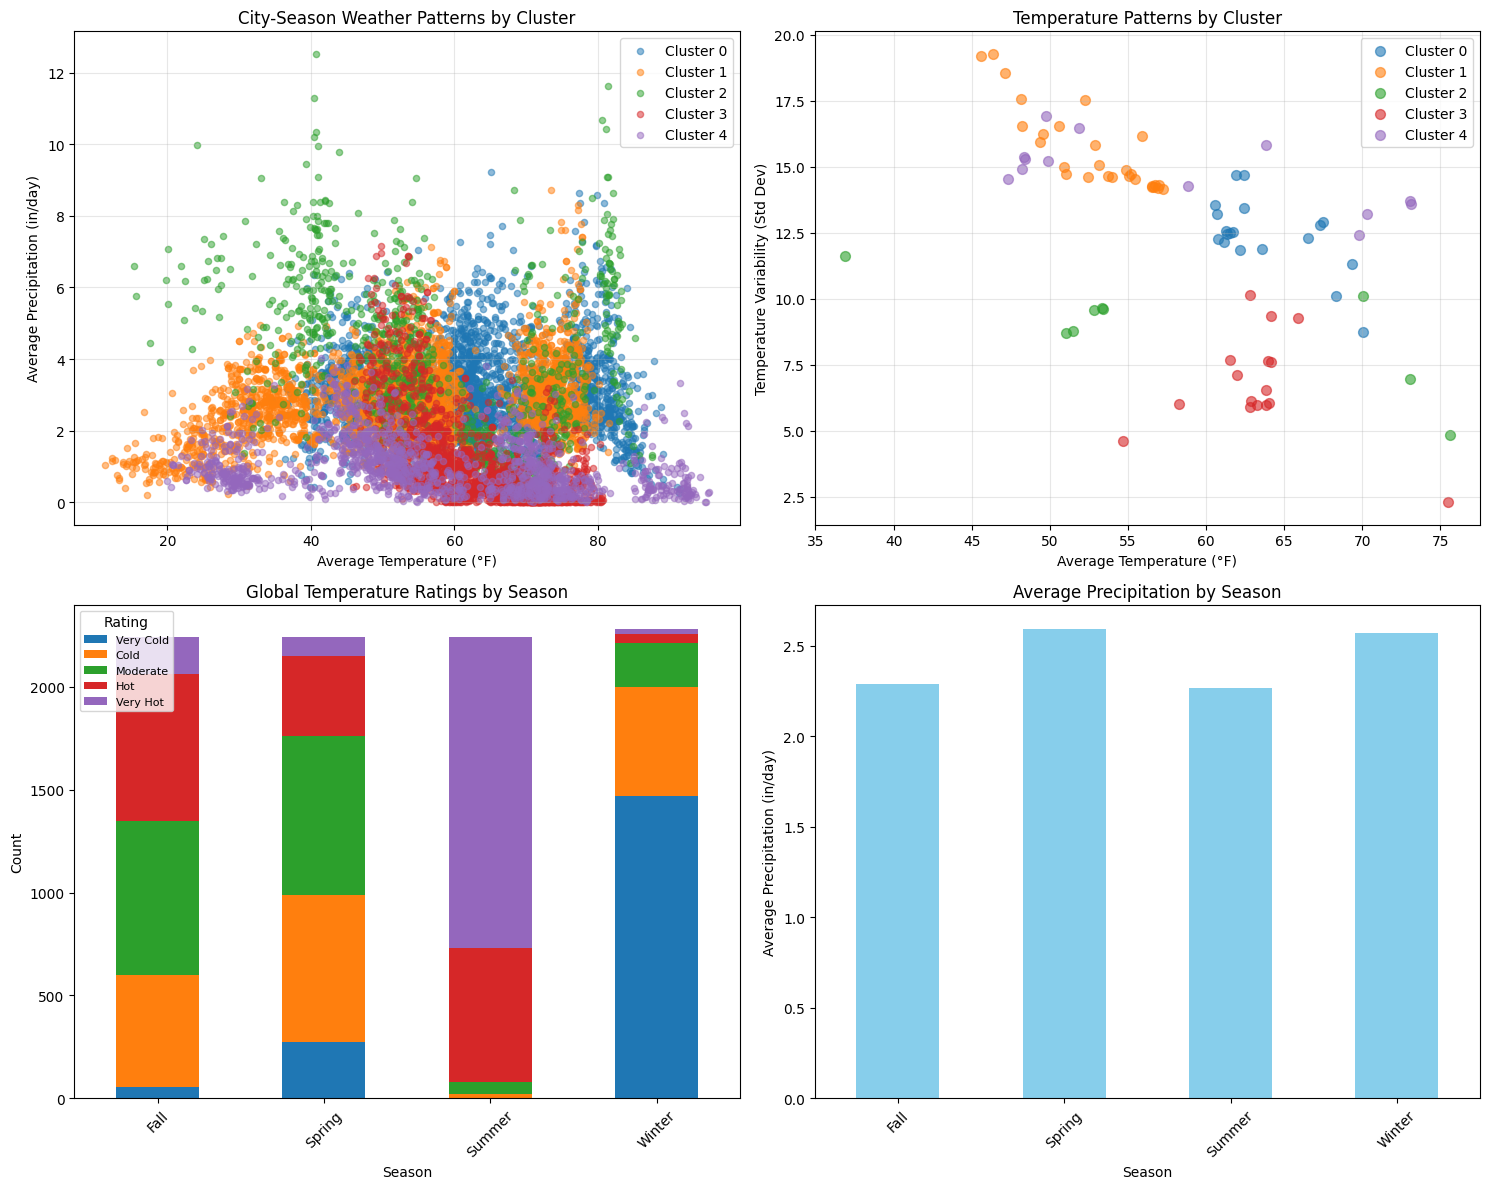


Correlation between Global and Local Ratings:

Temperature ratings correlation:
                           global_temperature_rating  local_temperature_rating
global_temperature_rating                   1.000000                  0.770685
local_temperature_rating                    0.770685                  1.000000

Precipitation ratings correlation:
                      global_precip_rating  local_precip_rating
global_precip_rating              1.000000             0.614624
local_precip_rating               0.614624             1.000000


In [25]:
# Create visualizations of temperature and precipitation by cluster
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Merge cluster information back to city_season_weather
city_season_weather_with_cluster = city_season_weather.merge(
    city_profiles_clean[['city', 'state', 'cluster']],
    on=['city', 'state'],
    how='left'
)

# Temperature by cluster - only plot non-null clusters
ax = axes[0, 0]
for cluster_id in range(n_clusters):
    cluster_data = city_season_weather_with_cluster[
        city_season_weather_with_cluster['cluster'] == cluster_id
    ]
    if len(cluster_data) > 0:
        ax.scatter(cluster_data['avg_temp'], cluster_data['avg_precip'], 
                  label=f'Cluster {cluster_id}', alpha=0.5, s=20)
ax.set_xlabel('Average Temperature (°F)')
ax.set_ylabel('Average Precipitation (in/day)')
ax.set_title('City-Season Weather Patterns by Cluster')
ax.legend()
ax.grid(True, alpha=0.3)

# Temperature variability by cluster
ax = axes[0, 1]
for cluster_id in range(n_clusters):
    cluster_data = city_profiles_clean[city_profiles_clean['cluster'] == cluster_id]
    if len(cluster_data) > 0:
        ax.scatter(cluster_data['avg_temp_overall'], cluster_data['temp_variability'],
                  label=f'Cluster {cluster_id}', alpha=0.6, s=50)
ax.set_xlabel('Average Temperature (°F)')
ax.set_ylabel('Temperature Variability (Std Dev)')
ax.set_title('Temperature Patterns by Cluster')
ax.legend()
ax.grid(True, alpha=0.3)

# Global ratings distribution by season
ax = axes[1, 0]
rating_by_season = city_season_weather.groupby(['season', 'global_temperature_rating']).size().unstack(fill_value=0)
rating_by_season.plot(kind='bar', stacked=True, ax=ax, legend=False)
ax.set_xlabel('Season')
ax.set_ylabel('Count')
ax.set_title('Global Temperature Ratings by Season')
ax.legend(title='Rating', labels=['Very Cold', 'Cold', 'Moderate', 'Hot', 'Very Hot'], 
         loc='upper left', fontsize=8)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Precipitation patterns by season
ax = axes[1, 1]
precip_by_season = city_season_weather.groupby('season')['avg_precip'].mean()
precip_by_season.plot(kind='bar', ax=ax, color='skyblue')
ax.set_xlabel('Season')
ax.set_ylabel('Average Precipitation (in/day)')
ax.set_title('Average Precipitation by Season')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Show correlation between global and local ratings
print("\n" + "="*80)
print("Correlation between Global and Local Ratings:")
print("="*80)
temp_correlation = city_season_weather[['global_temperature_rating', 'local_temperature_rating']].corr()
precip_correlation = city_season_weather[['global_precip_rating', 'local_precip_rating']].corr()

print("\nTemperature ratings correlation:")
print(temp_correlation)
print("\nPrecipitation ratings correlation:")
print(precip_correlation)

## Step 6: Save Final Weather Classification Dataset
Save the dataset with local and global ratings for use in downstream analysis.

In [26]:
# Select columns for the final dataset
weather_classification = city_season_weather[[
    'city',
    'state', 
    'year',
    'season',
    'avg_temp',
    'avg_temp_min',
    'avg_temp_max',
    'avg_precip',
    'total_precip',
    'days_with_precip',
    'day_count',
    'local_temperature_rating',
    'global_temperature_rating',
    'local_precip_rating',
    'global_precip_rating'
]].copy()

# Add cluster information
weather_classification = weather_classification.merge(
    city_profiles_clean[['city', 'state', 'cluster']],
    on=['city', 'state'],
    how='left'
)

# Save to CSV
output_path = "../data/weather_classification.csv"
weather_classification.to_csv(output_path, index=False)

print(f"Saved weather classification dataset to {output_path}")
print(f"Shape: {weather_classification.shape}")
print("\nColumn summary:")
print(weather_classification.dtypes)
print("\nFirst few rows:")
print(weather_classification.head(10))

# Print summary statistics
print("\n" + "="*80)
print("Summary Statistics:")
print("="*80)
print(f"Total records: {len(weather_classification):,}")
print(f"Cities: {weather_classification['city'].nunique()}")
print(f"City/State combinations: {weather_classification.groupby(['city', 'state']).ngroups}")
print(f"Years covered: {weather_classification['year'].min()} - {weather_classification['year'].max()}")
print(f"\nRecords by season:")
print(weather_classification['season'].value_counts().sort_index())
print(f"\nRecords by cluster (NaN means insufficient data):")
print(weather_classification['cluster'].value_counts(dropna=False).sort_index())

Saved weather classification dataset to ../data/weather_classification.csv
Shape: (9010, 16)

Column summary:
city                             str
state                            str
year                           int32
season                           str
avg_temp                     float64
avg_temp_min                 float64
avg_temp_max                 float64
avg_precip                   float64
total_precip                 float64
days_with_precip               int64
day_count                      int64
local_temperature_rating       int64
global_temperature_rating      int64
local_precip_rating            int64
global_precip_rating           int64
cluster                        int32
dtype: object

First few rows:
          city state  year  season   avg_temp  avg_temp_min  avg_temp_max  \
0  albuquerque    nm  1999    Fall  60.399451     48.592308     72.206593   
1  albuquerque    nm  1999  Spring  56.421196     43.410870     69.431522   
2  albuquerque    nm  1999  Summer  